<a href="https://colab.research.google.com/github/Kryptera-K/UBER-Bear-WR-Rise-Overbought-Strategy/blob/main/UBER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "UBER"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("UBER_clean.csv", index=False)
df

/tmp/ipython-input-281512301.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2019-05-10,41.570000,45.000000,41.060001,42.000000,186322500
2019-05-13,37.099998,39.240002,36.080002,38.790001,79442400
2019-05-14,39.959999,39.959999,36.849998,38.310001,46661100
2019-05-15,41.290001,41.880001,38.950001,39.369999,36086100
2019-05-16,43.000000,44.060001,41.250000,41.480000,38115500
...,...,...,...,...,...
2025-10-24,94.070000,95.260002,93.900002,95.150002,12014600
2025-10-27,96.419998,96.660004,94.529999,94.910004,11748300
2025-10-28,95.430000,97.730003,95.410004,96.769997,17138300


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BEAR_POWER_SHIFT = 5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_OVERBOUGHT = 80
STOCHASTIC_OVERSOLD = 20
WR_LEVEL = -50
WR_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def bears_power_cross_above(df, period = BEAR_EMA_PERIOD, level=BEAR_POWER_LEVEL):
    df = calculate_bears_power(df, period)
    return (df['Bears_Power'].shift(1) <= level) & (df['Bears_Power'] > level)


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df


def wr_is_rising(df):
    df = calculate_williams_r(df)
    return df['Williams_%R'].diff() > 0


def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df


def fast_k_cross_below_overbought(df, level=STOCHASTIC_OVERBOUGHT):
    df = calculate_stochastic(df)
    return (df['Fast_%K'].shift(1) > level) & (df['Fast_%K'] < level)


def calculate_stochastic(df, k_period=STOCHASTIC_K_PERIOD, d_period=STOCHASTIC_D_PERIOD):
    """Calculate Fast %K and Slow %D"""
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()

    df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
    df['Slow_%D'] = df['Fast_%K'].rolling(window=d_period).mean()
    return df


def qqe_value1_lower_than_value2(df):
    df = calculate_qqe(df)
    return df['QQE_Value1'] < df['QQE_Value2']


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df



# -------------------------
# Entry conditions
# -------------------------

df["BearP_Cross_Above_0"] = bears_power_cross_above(df)
df["WR_is_Rising"] = wr_is_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["Stochastic_Fast_%K_Cross_Below_Overbought"] = fast_k_cross_below_overbought(df)
df["QQE_Value1_LowerThan_Value2"] = qqe_value1_lower_than_value2(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BearP_Cross_Above_0',
    'WR_is_Rising',
]
exit_conditions = [
    'Stochastic_Fast_%K_Cross_Below_Overbought',
    'QQE_Value1_LowerThan_Value2',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-1277124726.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2019-05-10 00:00:00
End                                  2025-10-30 00:00:00
Period                                1629 days 00:00:00
Start Value                                     100000.0
End Value                                   262425.53078
Total Return [%]                              162.425531
Benchmark Return [%]                          127.166675
Max Gross Exposure [%]                             100.0
Total Fees Paid                             15303.635367
Max Drawdown [%]                               43.058129
Max Drawdown Duration                  605 days 00:00:00
Total Trades                                          50
Total Closed Trades                                   49
Total Open Trades                                      1
Open Trade PnL                             -11574.543349
Win Rate [%]                                   55.102041
Best Trade [%]                                 47.052729
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2019-05-10 00:00:00
End                           2025-10-30 00:00:00
Period                         1629 days 00:00:00
Start Value                              100000.0
End Value                           227166.675386
Total Return [%]                       127.166675
Benchmark Return [%]                   127.166675
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        67.794465
Max Drawdown Duration           723 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      127166.675386
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1410401757.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1410401757.py:57: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



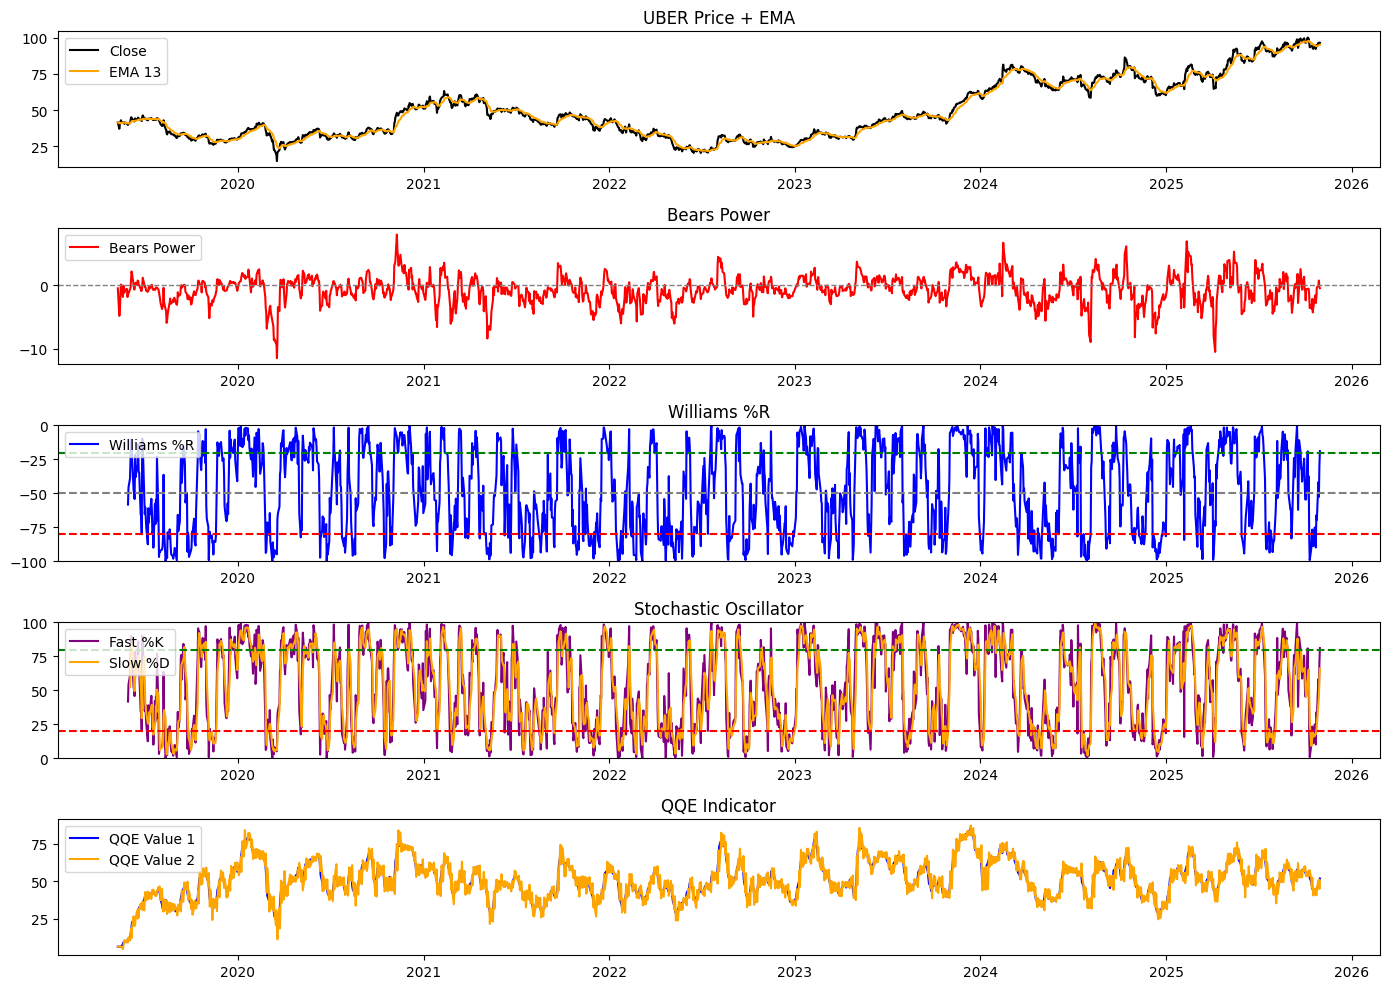

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "UBER"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Indicator Parameters
# -------------------------
BEAR_EMA_PERIOD = 13
QQE_FACTOR = 4.236
QQE_PERIOD = 14
QQE_SMOOTH = 5
STOCHASTIC_K_PERIOD = 14
STOCHASTIC_D_PERIOD = 3
STOCHASTIC_OVERBOUGHT = 80
STOCHASTIC_OVERSOLD = 20
WR_PERIOD = 14

# -------------------------
# Indicator Calculations
# -------------------------

# --- Bears Power ---
df['EMA'] = df['Close'].ewm(span=BEAR_EMA_PERIOD, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']

# --- Williams %R ---
highest_high = df['High'].rolling(window=WR_PERIOD).max()
lowest_low = df['Low'].rolling(window=WR_PERIOD).min()
df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)

# --- Stochastic ---
low_min = df['Low'].rolling(window=STOCHASTIC_K_PERIOD).min()
high_max = df['High'].rolling(window=STOCHASTIC_K_PERIOD).max()
df['Fast_%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['Slow_%D'] = df['Fast_%K'].rolling(window=STOCHASTIC_D_PERIOD).mean()

# --- QQE ---
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
roll_up = up.ewm(alpha=1/QQE_PERIOD, adjust=False).mean()
roll_down = down.ewm(alpha=1/QQE_PERIOD, adjust=False).mean()
rsi = 100 - (100 / (1 + roll_up / roll_down))

rsi_ma = rsi.rolling(window=QQE_SMOOTH).mean().fillna(method='bfill')
rsi_delta = rsi_ma.diff().abs().fillna(0)
atr_rsi = rsi_delta.ewm(alpha=1/QQE_SMOOTH, adjust=False).mean()

value1 = rsi_ma.copy()
value2 = pd.Series(index=df.index, dtype=float)
value2.iloc[0] = value1.iloc[0]
for i in range(1, len(df)):
    prev_trail = value2.iloc[i-1]
    prev_value1 = value1.iloc[i-1]
    atr = atr_rsi.iloc[i]
    direction = 1 if prev_value1 > prev_trail else -1
    value2.iloc[i] = prev_trail + direction * QQE_FACTOR * atr
df['QQE_Value1'] = value1
df['QQE_Value2'] = value2

# -------------------------
# Plotting
# -------------------------

plt.figure(figsize=(14, 10))

# 1️⃣ Price with EMA
ax1 = plt.subplot(5, 1, 1)
ax1.plot(df.index, df['Close'], label='Close', color='black')
ax1.plot(df.index, df['EMA'], label=f'EMA {BEAR_EMA_PERIOD}', color='orange')
ax1.set_title(f"{symbol} Price + EMA")
ax1.legend(loc="upper left")

# 2️⃣ Bears Power
ax2 = plt.subplot(5, 1, 2, sharex=ax1)
ax2.plot(df.index, df['Bears_Power'], label='Bears Power', color='red')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_title("Bears Power")
ax2.legend(loc="upper left")

# 3️⃣ Williams %R
ax3 = plt.subplot(5, 1, 3, sharex=ax1)
ax3.plot(df.index, df['Williams_%R'], label='Williams %R', color='blue')
ax3.axhline(-50, color='gray', linestyle='--')
ax3.axhline(-20, color='green', linestyle='--')
ax3.axhline(-80, color='red', linestyle='--')
ax3.set_ylim([-100, 0])
ax3.set_title("Williams %R")
ax3.legend(loc="upper left")

# 4️⃣ Stochastic Oscillator
ax4 = plt.subplot(5, 1, 4, sharex=ax1)
ax4.plot(df.index, df['Fast_%K'], label='Fast %K', color='purple')
ax4.plot(df.index, df['Slow_%D'], label='Slow %D', color='orange')
ax4.axhline(STOCHASTIC_OVERBOUGHT, color='green', linestyle='--')
ax4.axhline(STOCHASTIC_OVERSOLD, color='red', linestyle='--')
ax4.set_ylim([0, 100])
ax4.set_title("Stochastic Oscillator")
ax4.legend(loc="upper left")

# 5️⃣ QQE
ax5 = plt.subplot(5, 1, 5, sharex=ax1)
ax5.plot(df.index, df['QQE_Value1'], label='QQE Value 1', color='blue')
ax5.plot(df.index, df['QQE_Value2'], label='QQE Value 2', color='orange')
ax5.set_title("QQE Indicator")
ax5.legend(loc="upper left")

plt.tight_layout()
plt.show()
